In [4]:
import cartopy.crs as ccrs
import numpy as np
import os
import pandas as pd
import pyproj
import sys
import ultraplot as uplt
import warnings
import rasterio as rio
from rasterio.plot import reshape_as_image

sys.path.append('../scripts/')
from drifter import compute_along_across_components, compute_velocity
from scipy.interpolate import interp1d
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore')

uplt.rc['geo.round'] = False
uplt.rc['reso'] = 'med'
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)
ref_img = rio.open("../data/modis_images/landmask.tiff")
crs0 = pyproj.CRS('WGS84')
crs1 = pyproj.CRS(ref_img.crs)
transformer = pyproj.Transformer.from_crs(crs0, crs_to=crs1, always_xy=True)
left, bottom, right, top = ref_img.bounds

In [5]:
def regrid_trajectory(group, datetime_grid, variables=['x_stere', 'y_stere']):
    """Estimate the location at 12 UTC using linear interpolation.
    Group should have datetime index. """
    group = group.sort_index()
    begin = group.index.min()
    end = group.index.max()

    if len(datetime_grid.loc[slice(begin, end)]) > 1:
        t0 = group.index.round('12h').min()
        t1 = group.index.round('12h').max()
        max_extrap = pd.to_timedelta('2h')
        if np.abs(t0 - begin) < max_extrap:
            begin = t0
        if np.abs(t1 - end) < max_extrap:
            end = t1

        X = group[variables].T #.rolling(
            #'1H', center=True).mean().T.values
        t_new = datetime_grid.loc[slice(begin, end)].values
        t_seconds = group['t'].values
        Xnew = interp1d(t_seconds, X,
                        bounds_error=False,
                        kind='linear', fill_value='extrapolate')(t_new)
        idx = ~np.isnan(Xnew.sum(axis=0))

        df_new = pd.DataFrame(data=np.round(Xnew.T, 5), 
                              columns=variables,
                              index=datetime_grid.loc[slice(begin, end)].index)
        return df_new
    
    else:
        df = pd.DataFrame(data = np.nan, columns=group.columns, index=[begin])
        df.drop(['t'], axis=1, inplace=True)
        return df

In [6]:
def get_month_folder(date):
    """Simple utility for navigating file structure"""
    start = '{y}{m}01'.format(y=date.year,
                              m=str(date.month).zfill(2))
    end = '{y}{m}01'.format(y=date.year,
                              m=str(date.month + 1).zfill(2))
    if (date.month == 3) | (date.month == 4):
        start = '{y}0331'.format(y=date.year)
        end = '{y}0501'.format(y=date.year)
    
    return '-'.join(['fram_strait', start, end])

In [7]:
floe_lib_clean = {}
for file in os.listdir('../data/floe_tracker/ift_floe_property_tables/clean/'):
    if 'csv' in file: 
        year = int(file.replace('.csv', '').split('_')[-1])
        floe_lib_clean[year] = pd.read_csv('../data/floe_tracker/ift_floe_property_tables/clean/' + file,
                                         index_col=0, dtype={'classification': str})
        floe_lib_clean[year]['datetime'] = pd.to_datetime(floe_lib_clean[year]['datetime'])
floe_lib_clean = pd.concat(floe_lib_clean).reset_index()
tracked_floes = floe_lib_clean.loc[floe_lib_clean.floe_id != 'unmatched']
tracked_floes.rename({'datetime': 'overpass_time'}, axis=1, inplace=True)
tracked_floes['datetime'] = tracked_floes['overpass_time'].dt.round('12h')

In [11]:
tracked_interpolated_floes = pd.read_csv('../data/floe_tracker/ift_floe_trajectories.csv', index_col=0, parse_dates=['datetime'])
# 8 pixel shift minimizes error against manual boundaries
tracked_interpolated_floes['area_adj_km2'] = (np.sqrt(tracked_interpolated_floes.area) + 8)**2*.25*.25 

# Give each floe a unique color
colors = [c['color'] for c in uplt.Cycle('Dark2', 15)]
floe_ids = tracked_interpolated_floes.floe_id.unique()
colors = np.random.choice(colors, len(floe_ids))
floe_colors = {f: c for f, c in zip(floe_ids, colors)}

In [9]:
# Load information on buoy data overlaps with IFT
iabp_meta = pd.read_csv('../data/iabp_miz_data/metadata.csv', index_col=0)

# This loads all the buoy data and selects the portion that overlaps with potential IFT observations
# by restricting the time range and the spatial window.
data_loc = '../data/iabp_miz_data/'
buoy_data = {}
for year in range(2003, 2021):
    df = pd.read_csv(data_loc + 'iabp_data_{y}.csv'.format(y=year),
                     index_col=0, parse_dates=['datetime'])
    df['x_stere'], df['y_stere'] = transformer.transform(df.longitude, df.latitude)
    start_date = pd.to_datetime('{y}-04-01'.format(y=year))
    end_date = pd.to_datetime('{y}-09-30'.format(y=year))
    in_scene = df.x_stere.between(left, right) & df.y_stere.between(bottom, top)
    in_timerange = df.datetime.between(start_date, end_date)
    sel_idx = in_scene & in_timerange
    df_counts = df.loc[sel_idx].groupby('buoy_id').count()
    if len(df_counts) > 0:
        if len(df.loc[sel_idx]) > 100:
            buoy_data[year] = df.loc[in_scene & in_timerange].copy()

In [10]:
iabp_meta.loc[iabp_meta.year == 2019]

,year,buoy_id,resolution,start_date,end_date,include
48,2019,300234064819910,2h,2019-04-01 01:00,2019-05-01 21:00,True
49,2019,300234065801040,1h,2019-09-07 08:00,2019-09-30 00:00,True
50,2019,300234066304040,6h,2019-04-01 00:00,2019-08-01 00:00,True
51,2019,300234066340550,1h,2019-04-01 00:00,2019-04-09 20:00,False
52,2019,300234066341810,1h,2019-04-01 00:00,2019-06-04 03:00,True


In [12]:
# Select buoy, get spatial window, and regrid buoy
year = 2019
buoy_id = 300234066304040
buoy_dfs = {buoy_id: group for buoy_id, group in buoy_data[year].groupby('buoy_id')}
buoy_df = buoy_dfs[buoy_id].set_index('datetime')

start_date = pd.to_datetime('{y}-06-01'.format(y=year))
end_date = pd.to_datetime('{y}-06-16'.format(y=year))
ts = slice(start_date, end_date)

x0 = buoy_df.loc[ts, 'x_stere'].mean()
y0 = buoy_df.loc[ts, 'y_stere'].mean()
dx = max(buoy_df.loc[ts, 'x_stere'].max() - buoy_df.loc[ts, 'x_stere'].min(), 
         buoy_df.loc[ts, 'y_stere'].max() - buoy_df.loc[ts, 'y_stere'].min())
n = np.ceil(dx / 256)
print(dx / 1e3)
print(n * 256)
dx = n * 256 # Update size so that it's an even number of pixels

# Regrid to 12 UTC
dt = pd.to_timedelta('12h')
date_grid = pd.date_range(start_date + dt, end_date + dt, freq='1d') 
ref_time = date_grid.min()
t_grid = (date_grid - ref_time).total_seconds()
datetime_grid = pd.Series(t_grid, index=date_grid)

buoy_df['t'] = (buoy_df.index - ref_time).total_seconds()
buoy_df_gridded = regrid_trajectory(buoy_df.loc[slice(start_date, end_date), :],
                          datetime_grid=datetime_grid,
                          variables=['latitude', 'longitude', 'x_stere', 'y_stere'])
buoy_df_gridded = compute_velocity(buoy_df_gridded, method='f')

107.02120788666257
107264.0


In [13]:
print('Half-width:', dx / 1e3, 'Num pixels:', (2 * dx) / 256)

Half-width: 107.264 Num pixels: 838.0


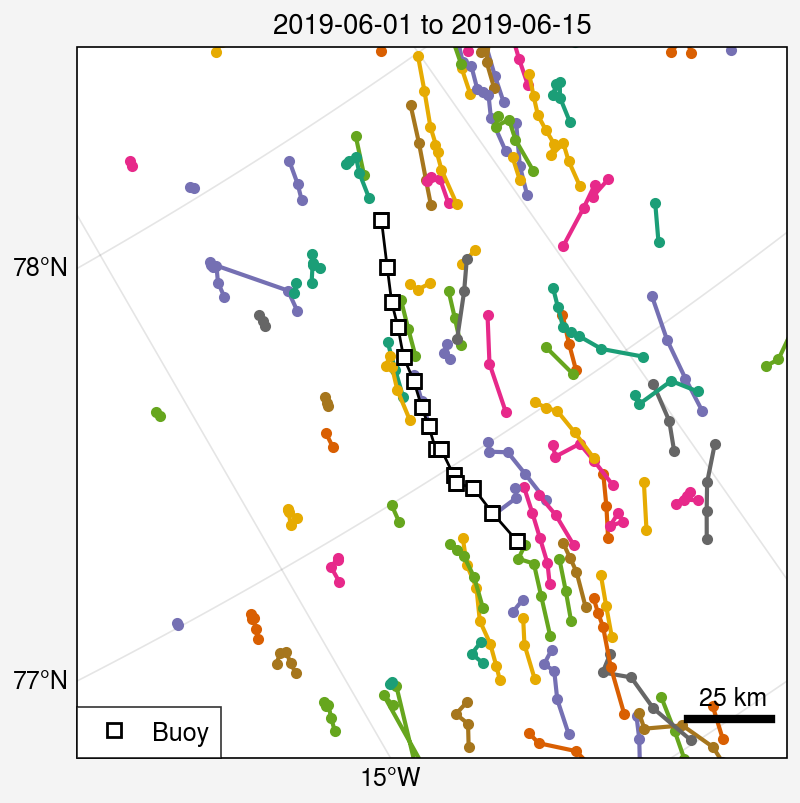

In [14]:
ts = slice(start_date, end_date)
df_sel = tracked_interpolated_floes.loc[tracked_interpolated_floes.datetime.between(start_date, end_date), :]
fig, axs = uplt.subplots(width=4, proj='npstere',
                         proj_kw={'lon_0': -45}, share=False)
axs.format(land=True, lonlocator=np.arange(-100, 30, 5), latmax=85, 
           latlocator=np.arange(55, 85, 1), latlabels=True, lonlabels=True)
axs.set_extent([x0 - dx, x0 + dx, y0 - dx, y0 + dx], crs=crs)  

for floe, group in df_sel.groupby('floe_id'):
    group = group.set_index('datetime')
    axs.plot(group.loc[ts, 'longitude'], group.loc[ts, 'latitude'],
             marker='.', color=floe_colors[floe], label='')    
axs.plot(buoy_df_gridded.loc[ts, 'longitude'], buoy_df_gridded.loc[ts, 'latitude'], color='k', lw=1, label='')
axs.plot(buoy_df_gridded.loc[ts, 'longitude'], buoy_df_gridded.loc[ts, 'latitude'], marker='s', ms=5, lw=0, edgecolor='k', color='w', label='Buoy')
axs.legend()

# scale bar
axs.text(x0 + 0.75*dx, y0 - 0.85*dx, '25 km', transform=crs)
left_x_scalebar = x0 + 0.72*dx
y_scalebar = y0 - 0.89*dx
axs.plot([left_x_scalebar, left_x_scalebar + 25e3], [y_scalebar, y_scalebar], lw=3, transform=crs, color='k')
axs.format(title='2019-06-01 to 2019-06-15')

The above figure shows the floe trajectories from the time period under consideration, compared with the IABP buoy. There are many gaps in the trajectories, but there are also periods where the floes move alongside the buoy.

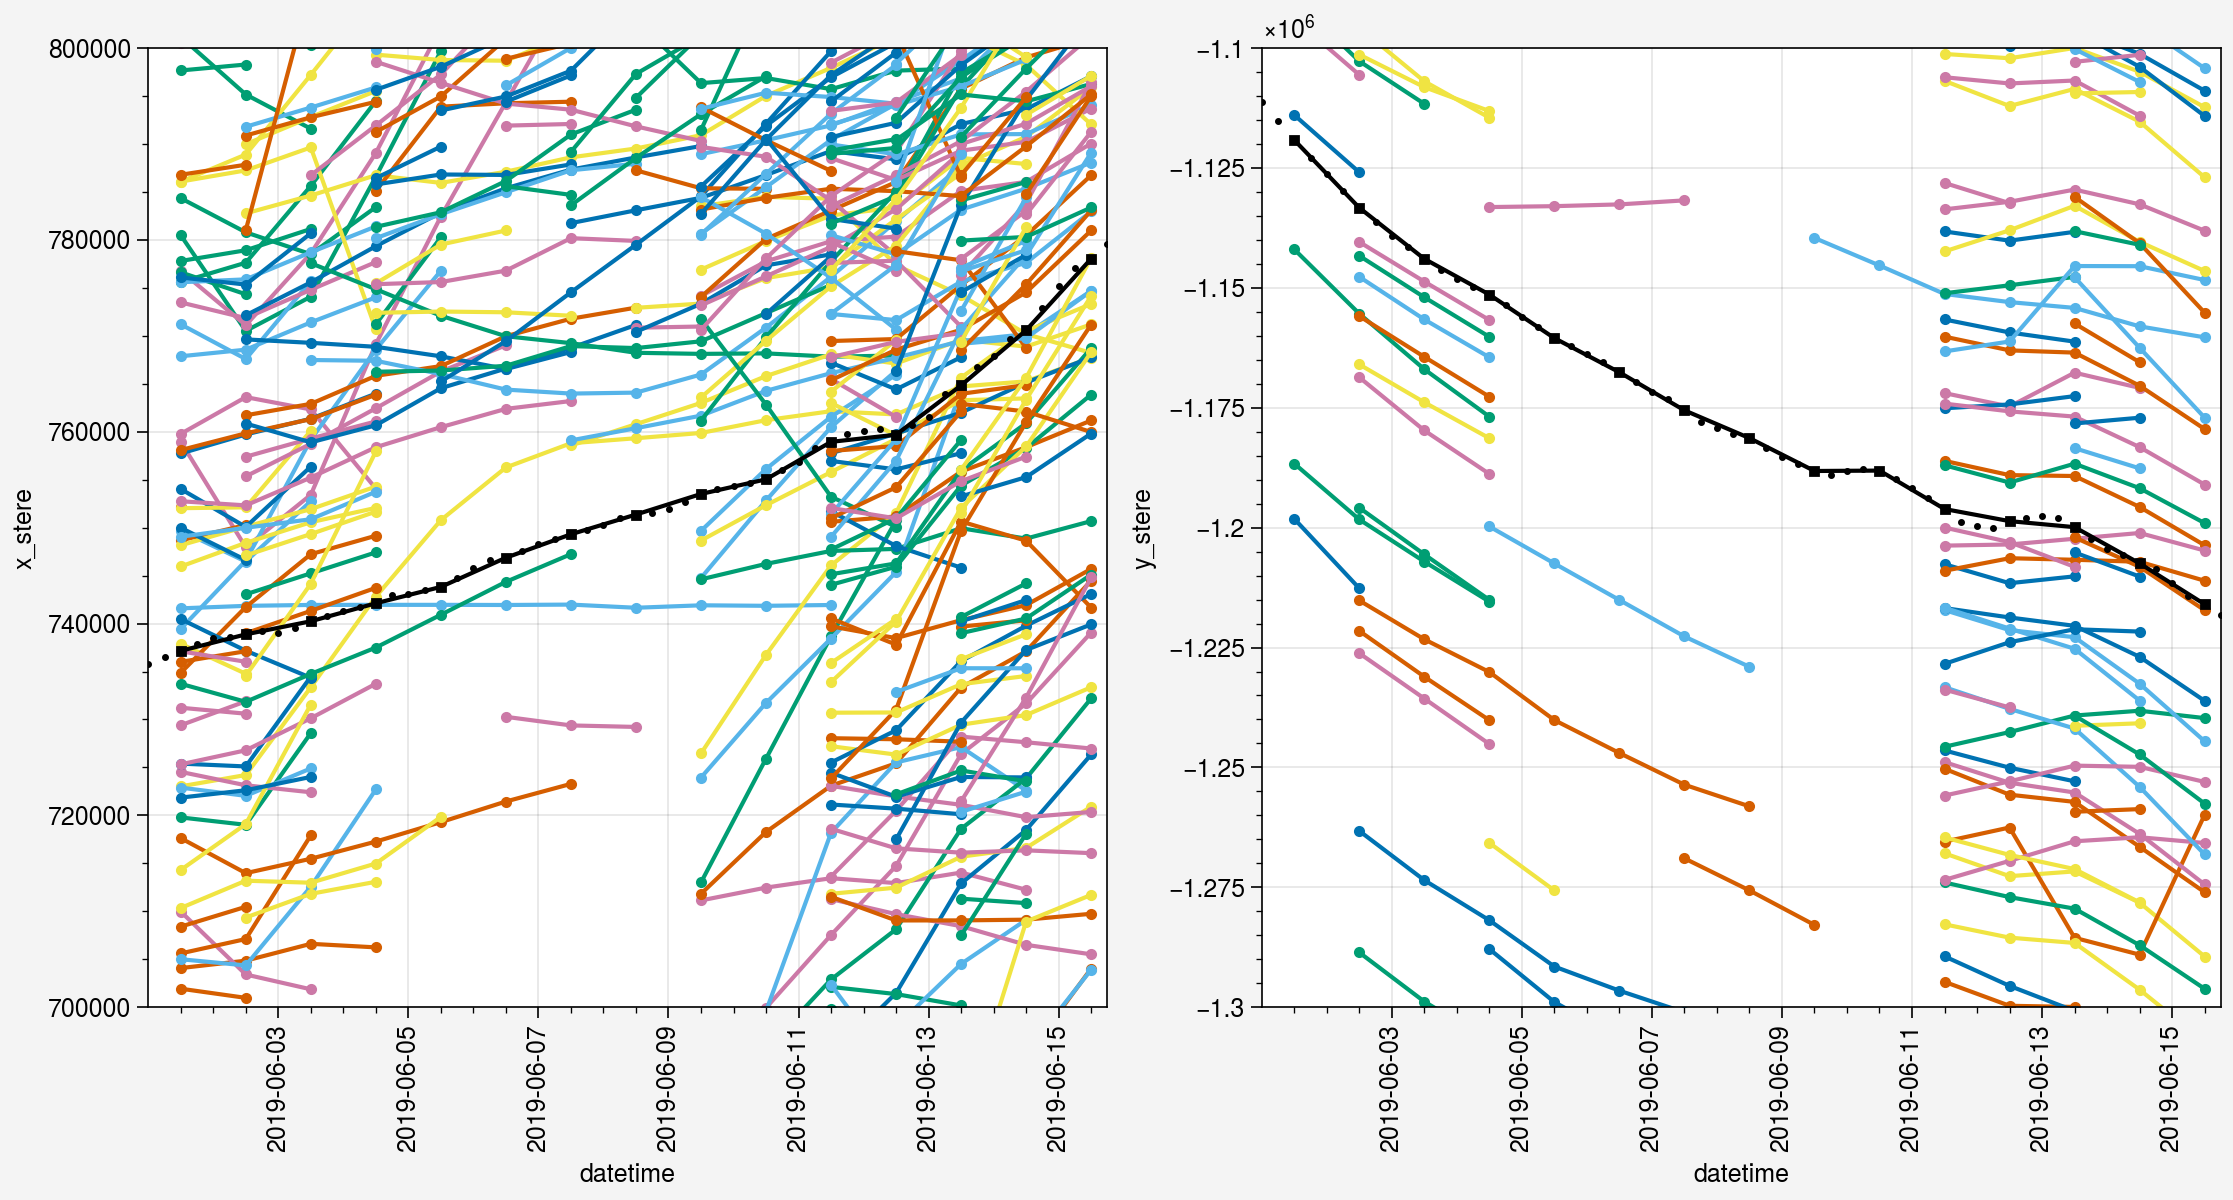

In [480]:
fig, axs = uplt.subplots(height=6, ncols=2, share=False)
ax = axs[0]
for floe, group in df_sel.groupby('floe_id'):
    group = group.set_index('datetime')
    ax.plot(group.loc[ts].index, group.loc[ts, 'x_stere'], marker='.')    
ax.plot(buoy_df.loc[ts].index, buoy_df.loc[ts, 'x_stere'], marker='.', lw=0,  ms=3, color='k')
ax.plot(buoy_df_gridded.loc[ts].index, buoy_df_gridded.loc[ts, 'x_stere'], marker='s', ms=3, color='k')
ax.format(ylim=(700e3, 800e3))

ax = axs[1]
for floe, group in df_sel.groupby('floe_id'):
    group = group.set_index('datetime')
    ax.plot(group.loc[ts].index, group.loc[ts, 'y_stere'], marker='.')    
ax.plot(buoy_df.loc[ts].index, buoy_df.loc[ts, 'y_stere'], marker='.', lw=0,  ms=3, color='k')
ax.plot(buoy_df_gridded.loc[ts].index, buoy_df_gridded.loc[ts, 'y_stere'], marker='s', ms=3, color='k')
ax.format(ylim=(-1.3e6, -1.1e6))


Next we overlay the images on the true color images. We select a spatial window surrounding the buoy and read only that part of the image.

In [465]:
# Need to mount the share drive to get the imagery
dataloc = "/Volumes/Research/ENG_Wilhelmus_Shared/group/IFT_fram_strait_dataset/"

tc_images = {}
matlab_floe_images = {}
clean_floe_images = {}

# Set a window so that we don't have to read the whole image every time.
from rasterio.windows import Window
row0, col0 = ref_img.index(x0 - dx, y0 + dx)
row1, col1 = ref_img.index(x0 + dx, y0 - dx)
window = Window(col, row, col1 - col0, row1 - row0)
data = ref_img.read(window=window)
new_left, new_top = ref_img.xy(row0, col0)
new_right, new_bottom = ref_img.xy(row1, col1)

def get_month_folder(date):
    """Simple utility for navigating file structure"""
    start = '{y}{m}01'.format(y=date.year,
                              m=str(date.month).zfill(2))
    end = '{y}{m}01'.format(y=date.year,
                              m=str(date.month + 1).zfill(2))
    if (date.month == 3) | (date.month == 4):
        start = '{y}0331'.format(y=date.year)
        end = '{y}0501'.format(y=date.year)
    
    return '-'.join(['fram_strait', start, end])
    
for date in pd.date_range('2019-06-01', '2019-06-25'):
    satellite = 'aqua'
    tc_images[date] = rio.open(dataloc + 'fram_strait-{y}/{m}/truecolor/{d}.{s}.truecolor.250m.tiff'.format(
        d=date.strftime('%Y%m%d'), s=satellite, y=date.year, m=get_month_folder(date))).read(window=window)
    matlab_floe_images[date] = rio.open(dataloc + 'fram_strait-{y}/{m}/labeled_raw/{d}.{s}.labeled_raw.250m.tiff'.format(
        d=date.strftime('%Y%m%d'), s=satellite, y=date.year, m=get_month_folder(date))).read(window=window)
    clean_floe_images[date] = rio.open(dataloc + 'fram_strait-{y}/{m}/labeled_clean/{d}.{s}.labeled_clean.250m.tiff'.format(
        d=date.strftime('%Y%m%d'), s=satellite, y=date.year, m=get_month_folder(date))).read(window=window)

ref = rio.open(dataloc + 'fram_strait-{y}/{m}/landmask.tiff'.format(
        d=date.strftime('%Y%m%d'), s=satellite, y=date.year, m=get_month_folder(
            date)))
lm = ref.read(window=window)

In [466]:
# Plotting set 1: 
# Time series of images, to animate
buoy_df_gridded.index

DatetimeIndex(['2019-06-01', '2019-06-02', '2019-06-03', '2019-06-04',
               '2019-06-05', '2019-06-06', '2019-06-07', '2019-06-08',
               '2019-06-09', '2019-06-10', '2019-06-11', '2019-06-12',
               '2019-06-13', '2019-06-14', '2019-06-15'],
              dtype='datetime64[ns]', freq='D')

In [511]:
# We select the locations at the time of the Aqua image, and merge using the "datetime" column with local noon to 
# get the estimated daily drift.
in_scene = tracked_floes.x_stere.between(x0 - dx, x0 + dx) & tracked_floes.y_stere.between(y0 - dx, y0 + dx)
tracked_floes_aqua = tracked_floes.loc[in_scene & (tracked_floes.satellite=='aqua')].merge(tracked_interpolated_floes[['floe_id', 'datetime', 'u', 'v']], left_on=['floe_id', 'datetime'],
                   right_on=['floe_id', 'datetime'])


In [529]:
for date in buoy_df_gridded.index:
    fig, axs = uplt.subplots(width=4, proj='npstere',
                         proj_kw={'lon_0': -45}, share=False)
    axs.format(land=True, lonlocator=np.arange(-100, 30, 5), latmax=85, 
               latlocator=np.arange(55, 85, 1), latlabels=True, lonlabels=True)
    axs.set_extent([x0 - dx, x0 + dx, y0 - dx, y0 + dx], crs=crs)  
    dt = pd.to_timedelta('12h')
    tc = reshape_as_image(tc_images[date - dt])
    floes_raw = matlab_floe_images[date - dt].squeeze()
    floes_clean = clean_floe_images[date - dt].squeeze()
    floes_boundaries = floes_clean - skimage.morphology.erosion(floes_clean, skimage.morphology.disk(3))
    color_raw = '#ffa867ff' #orange
    color_clean = '#519cccff' #blue
    
    axs.imshow(tc, extent=[new_left, new_right, new_bottom, new_top], transform=crs)
    axs.imshow(np.ma.masked_array(floes_clean, floes_clean==0), color='tangerine', alpha=0.3, 
               extent=[new_left, new_right, new_bottom, new_top], transform=crs)
    axs.imshow(np.ma.masked_array(floes_raw, (floes_raw==0) | (floes_clean > 0)), color='sky blue', alpha=0.3,
               extent=[new_left, new_right, new_bottom, new_top], transform=crs)

    plot_floes = tracked_floes_aqua.loc[tracked_floes_aqua.datetime == date].set_index('floe_id')
    if len(plot_floes) > 0:
        print(len(plot_floes))
        for floe, data in plot_floes.iterrows():
            label = data.label
            axs.imshow(np.ma.masked_array(floes_boundaries, floes_boundaries != label), color=floe_colors[floe], alpha=1,
                   extent=[new_left, new_right, new_bottom, new_top], transform=crs)
            axs.plot(data['longitude'], data['latitude'], marker='.', color=floe_colors[floe])    
            axs.quiver(data['longitude'], data['latitude'], data['u'], data['v'], color=floe_colors[floe])    
   
    axs.plot(buoy_df_gridded.loc[date, 'longitude'], buoy_df_gridded.loc[date, 'latitude'], marker='s',
             ms=5, color='w', edgecolor='k', zorder=10)
    axs.quiver(buoy_df_gridded.loc[date, 'longitude'], buoy_df_gridded.loc[date, 'latitude'], 
               buoy_df_gridded.loc[date, 'u'], buoy_df_gridded.loc[date, 'v'], 
               color='k', zorder=11)
    
    # scale bar
    axs.text(x0 + 0.75*dx, y0 - 0.85*dx, '25 km', transform=crs)
    left_x_scalebar = x0 + 0.72*dx
    y_scalebar = y0 - 0.89*dx
    axs.plot([left_x_scalebar, left_x_scalebar + 25e3], [y_scalebar, y_scalebar], lw=3, transform=crs, color='k')
    axs.format(title=date.strftime('%Y-%m-%d'))
    fig.save('../figures/diagnostics/case_study_2019-06-01_2019-06-15/overlay_{d}.png'.format(d = date.strftime('%Y-%m-%d')), dpi=300)
    pplt.close(fig)

8
16
19
21
3
6
3
3
40
30
49
45
31


From these images, we can see some important points:
* The buoy is likely on a small floe (or in between floes)
* Nearby buoys do have very similar drift directions
* There are many cases where it is surprising that the tracker failed

For the paper, I'm making a four-panel figure with the 4 days in a row with good coverage.

DatetimeIndex(['2019-06-11 12:00:00', '2019-06-12 12:00:00',
               '2019-06-13 12:00:00', '2019-06-14 12:00:00'],
              dtype='datetime64[ns]', freq=None)

In [537]:
fig, axs = uplt.subplots(width=8, nrows=2, ncols=2, proj='npstere',
                         proj_kw={'lon_0': -45}, share=False)
for ax, date in zip(axs, buoy_df_gridded.index[10:14]):
    ax.format(land=True, lonlocator=np.arange(-100, 30, 5), latmax=85, 
               latlocator=np.arange(55, 85, 1), latlabels=True, lonlabels=True)
    ax.set_extent([x0 - dx, x0 + dx, y0 - dx, y0 + dx], crs=crs)  
    dt = pd.to_timedelta('12h')
    tc = reshape_as_image(tc_images[date - dt])
    floes_raw = matlab_floe_images[date - dt].squeeze()
    floes_clean = clean_floe_images[date - dt].squeeze()
    floes_boundaries = floes_clean - skimage.morphology.erosion(floes_clean, skimage.morphology.disk(3))
    color_raw = '#ffa867ff' #orange
    color_clean = '#519cccff' #blue
    
    ax.imshow(tc, extent=[new_left, new_right, new_bottom, new_top], transform=crs)
    ax.imshow(np.ma.masked_array(floes_clean, floes_clean==0), color='tangerine', alpha=0.3, 
               extent=[new_left, new_right, new_bottom, new_top], transform=crs)
    ax.imshow(np.ma.masked_array(floes_raw, (floes_raw==0) | (floes_clean > 0)), color='sky blue', alpha=0.3,
               extent=[new_left, new_right, new_bottom, new_top], transform=crs)

    plot_floes = tracked_floes_aqua.loc[tracked_floes_aqua.datetime == date].set_index('floe_id')
    if len(plot_floes) > 0:
        print(len(plot_floes))
        for floe, data in plot_floes.iterrows():
            label = data.label
            ax.imshow(np.ma.masked_array(floes_boundaries, floes_boundaries != label), color=floe_colors[floe], alpha=1,
                   extent=[new_left, new_right, new_bottom, new_top], transform=crs)
            df_prior = tracked_floes_aqua.loc[(tracked_floes_aqua.floe_id == floe) & 
                                               tracked_floes_aqua.datetime.between(start_date, date)]
            ax.plot(df_prior.longitude, df_prior.latitude, color=floe_colors[floe], marker='.', ms=3)
            ax.quiver(data['longitude'], data['latitude'], data['u'], data['v'], color=floe_colors[floe])    

    
    ax.plot(buoy_df_gridded.loc[date, 'longitude'], buoy_df_gridded.loc[date, 'latitude'], marker='s',
             ms=5, color='w', edgecolor='k', zorder=10)
    ax.quiver(buoy_df_gridded.loc[date, 'longitude'], buoy_df_gridded.loc[date, 'latitude'], 
               buoy_df_gridded.loc[date, 'u'], buoy_df_gridded.loc[date, 'v'], 
               color='k', zorder=11)

    # scale bar
    ax.text(x0 + 0.75*dx, y0 - 0.85*dx, '25 km', transform=crs)
    left_x_scalebar = x0 + 0.72*dx
    y_scalebar = y0 - 0.89*dx
    ax.plot([left_x_scalebar, left_x_scalebar + 25e3], [y_scalebar, y_scalebar], lw=3, transform=crs, color='k')
    ax.format(title=date.strftime('%Y-%m-%d'))
fig.save('../figures/diagnostics/case_study_2019-06-01_2019-06-15/fig04_trajectory_example.png', dpi=300)
pplt.close(fig)

40
30
49
45


Plotting this is super slow because I'm projecting into the NPS grid. The advantage is that I get lat/lon, the disadvantage is speed. In the future it would be best to extract the boundary coordinates in stereographic coordinates and then plot those polygons rather than doing morphology. If I draw them as dots it would not be super hard to do. Time running is about 7 minutes.

To do: 
* arrow for scale for the drift speed.
* move scale bar to top right
* plot outlines for previous days, both for aqua and for terra



To illustrate the comparison with the IABP data and the floe data, I'd like to select cases where the buoy is within 5 km of an ice floe. We can do a simple scatter plot with U and V for two of the panels, with color showing the distance between the buoy and the floe, and compute the correlation. Then, we can look at the difference in magnitude and angle as a function of distance. This is a measure of spatial correlation.

In [538]:
plot_floes = tracked_floes_aqua.loc[tracked_floes_aqua.datetime == date].set_index('floe_id')

In [539]:
plot_floes

,level_0,level_1,overpass_time,satellite,label,longitude,latitude,x_stere,y_stere,col_pixel,...,fc_channel0,fc_channel1,fc_channel2,init_classification,lr_probability,lr_classification,final_classification,datetime,u,v
floe_id,,,,,,,,,,,,,,,,,,,,,
2019_04580,2019,64448,2019-06-14 12:25:51,aqua,129,-12.6880,77.6743,716361.1,-1132646.8,1830.666667,...,1.7,221.7,238.5,TP,0.999,True,True,2019-06-14 12:00:00,-0.036933,-0.052047
2019_04573,2019,64451,2019-06-14 12:25:51,aqua,145,-11.5335,77.8160,730477.8,-1105035.8,1885.810207,...,1.2,225.5,241.5,TP,0.997,True,True,2019-06-14 12:00:00,-0.019277,-0.089942
2019_04572,2019,64452,2019-06-14 12:25:51,aqua,120,-15.5238,76.8027,706464.5,-1249882.6,1792.008078,...,2.6,217.5,236.2,TP,0.974,True,True,2019-06-14 12:00:00,-0.027886,-0.026048
2019_04552,2019,64458,2019-06-14 12:25:51,aqua,216,-9.6196,77.6480,777635.7,-1095032.0,2070.020675,...,1.5,226.3,242.2,TP,0.999,True,True,2019-06-14 12:00:00,-0.011855,-0.123614
2019_04547,2019,64459,2019-06-14 12:25:51,aqua,254,-9.4146,77.3873,798170.7,-1115472.8,2150.235546,...,2.2,225.3,240.7,TP,0.998,True,True,2019-06-14 12:00:00,-0.136537,-0.067411
2019_04540,2019,64461,2019-06-14 12:25:51,aqua,192,-13.0529,76.7083,765177.4,-1227057.6,2021.355599,...,2.6,219.6,237.4,TP,0.995,True,True,2019-06-14 12:00:00,-0.030497,-0.106137
2019_04537,2019,64463,2019-06-14 12:25:51,aqua,187,-14.1514,76.3183,763468.2,-1278262.1,2014.678788,...,1.6,220.5,238.4,TP,0.996,True,True,2019-06-14 12:00:00,NaN,NaN
2019_04529,2019,64465,2019-06-14 12:25:51,aqua,271,-12.2618,76.2979,806410.5,-1254273.5,2182.422239,...,3.4,222.3,239.3,TP,0.995,True,True,2019-06-14 12:00:00,-0.048976,-0.162436
2019_04527,2019,64466,2019-06-14 12:25:51,aqua,128,-15.3512,76.6266,719786.8,-1264544.3,1844.048209,...,2.0,218.0,235.7,TP,0.985,True,True,2019-06-14 12:00:00,-0.001409,-0.015194


In [15]:
import skimage


In [16]:
df_ift = tracked_interpolated_floes.loc[tracked_interpolated_floes.datetime.between(start_date, end_date), :]

In [18]:
iabp_meta['start_date'] = pd.to_datetime(iabp_meta.start_date)
iabp_meta['end_date'] = pd.to_datetime(iabp_meta.end_date)

In [545]:
iabp_meta.loc[iabp_meta.year == 2019]

,year,buoy_id,resolution,start_date,end_date,include
48,2019,300234064819910,2h,2019-04-01 01:00:00,2019-05-01 21:00:00,True
49,2019,300234065801040,1h,2019-09-07 08:00:00,2019-09-30 00:00:00,True
50,2019,300234066304040,6h,2019-04-01 00:00:00,2019-08-01 00:00:00,True
51,2019,300234066340550,1h,2019-04-01 00:00:00,2019-04-09 20:00:00,False
52,2019,300234066341810,1h,2019-04-01 00:00:00,2019-06-04 03:00:00,True


In [105]:
# Check this, I think it's likely wrong
results = {}
for idx in iabp_meta.index:
    year, buoy_id, res, start_date, end_date, include = iabp_meta.loc[idx, :]
    buoy_dfs = {buoy_id: group for buoy_id, group in buoy_data[year].groupby('buoy_id')}
    buoy_df = buoy_dfs[buoy_id]
    if 'datetime' in buoy_df.columns:
        buoy_df.set_index('datetime', inplace=True)
    idx = (buoy_df.index >= start_date) & (buoy_df.index <= end_date)
    buoy_df = buoy_df.loc[idx,:].copy()
    
    ift_sel = tracked_interpolated_floes.loc[tracked_interpolated_floes.datetime.between(start_date, end_date), :]

    if len(ift_sel) > 2:
        ift_sel.dropna()

        # Regrid to 12 UTC
        dt = pd.to_timedelta('12h')
        date_grid = pd.date_range(start_date + dt, end_date + dt, freq='1d') 
        ref_time = date_grid.min()
        t_grid = (date_grid - ref_time).total_seconds()
        datetime_grid = pd.Series(t_grid, index=date_grid)
        
        buoy_df['t'] = (buoy_df.index - ref_time).total_seconds()
        buoy_df_gridded = regrid_trajectory(buoy_df.loc[slice(start_date, end_date), :],
                                  datetime_grid=datetime_grid,
                                  variables=['latitude', 'longitude', 'x_stere', 'y_stere'])
        buoy_df_gridded = compute_velocity(buoy_df_gridded, method='f')
        
        buffer = 100e3
        ift_sel['close'] = False
        ift_sel['distance'] = np.nan
        ift_sel['u_stere'] = np.nan
        
        for time, data in buoy_df_gridded.iterrows():
            idx = ift_sel.datetime == time
            d = np.sqrt((ift_sel.loc[idx, 'x_stere'] - data.x)**2 + \
                        (ift_sel.loc[idx, 'y_stere'] - data.y)**2)
            new_idx = d[d < buffer].index
            ift_sel.loc[new_idx, 'close'] = True
            ift_sel.loc[new_idx, 'distance'] = d[new_idx]
            ift_sel.loc[new_idx, 'iabp_u'] = data.u
            ift_sel.loc[new_idx, 'iabp_v'] = data.v

        for floe_id, group in ift_sel.groupby('floe_id'):
            if np.any(group.distance.notnull()):
                vel = compute_velocity(group.set_index('datetime'), method='f')
                ift_sel.loc[group.index, 'u_stere'] = vel['u'].values
                ift_sel.loc[group.index, 'v_stere'] = vel['v'].values


        results[buoy_id] = ift_sel.dropna(subset='u_stere')

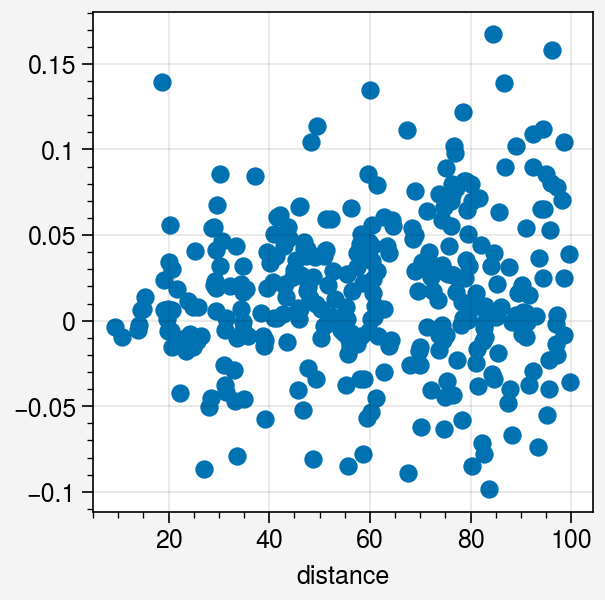

In [103]:
fig, ax = uplt.subplots()
ax.scatter(results[buoy_id].distance/1e3, results[buoy_id].iabp_u - results[buoy_id].u_stere,)

In [58]:
year = 2019
df = ift_sel.copy()
ref_time = pd.to_datetime(str(year) + '-01-01 00:00')
df['t'] = (df['datetime'] - ref_time).dt.total_seconds()

# Set up a regular grid for interpolation
date_grid = pd.date_range(str(year) + '-04-01 00:00', str(year) + '-09-30 00:00', freq='1D')
date_grid += pd.to_timedelta('12h') # Satellite overpass time is close to noon UTC
t_grid = (date_grid - ref_time).total_seconds()
datetime_grid = pd.Series(t_grid, index=date_grid)

# Apply interpolation and angle estimation
results = {}
for floe_id, group in df.groupby('floe_id'):
    group = group.loc[~group.datetime.duplicated()].copy()
    df_regrid = compute_velocity(group.set_index('datetime'), method='f')
    if np.any(df_regrid.notnull()):
        results[floe_id] = df_regrid.copy()

In [66]:
df = pd.concat(results).reset_index()
df.drop('level_0', axis=1, inplace=True)

ift_sel = df.copy()


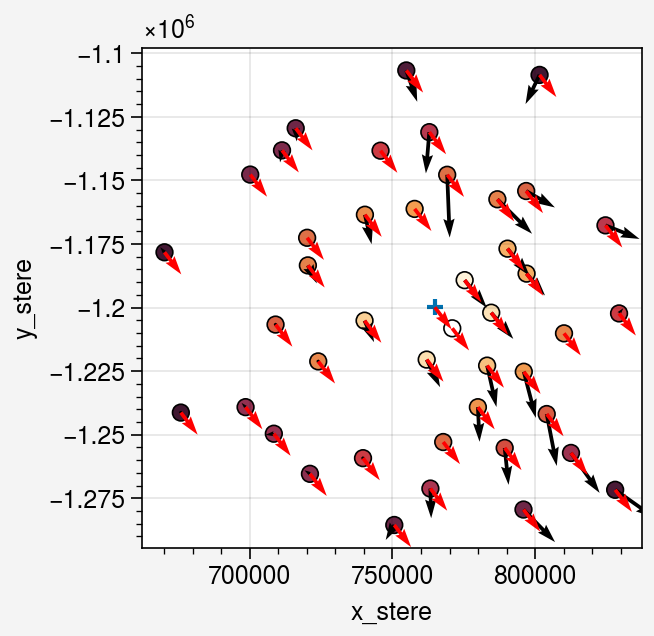

In [67]:
time = '2019-06-13 12:00'
data = buoy_df_gridded.loc[time, :]
idx = ift_sel.datetime == time
d = np.sqrt((ift_sel.loc[idx, 'x_stere'] - data.x)**2 + \
            (ift_sel.loc[idx, 'y_stere'] - data.y)**2)
ift_sel.loc[idx, 'dist'] = d
buffer = 100e3
fig, ax = pplt.subplots()
ax.scatter(data.x_stere, data.y_stere, marker='+')
ax.scatter(ift_sel.loc[ift_sel.dist < buffer].x_stere,
           ift_sel.loc[ift_sel.dist < buffer].y_stere,
          c = ift_sel.loc[ift_sel.dist < buffer].dist, edgecolor='k')
ax.quiver(data.x_stere, data.y_stere, data.u, data.v, color='r')

ax.quiver(ift_sel.loc[ift_sel.dist < buffer].x_stere,
           ift_sel.loc[ift_sel.dist < buffer].y_stere,
          ift_sel.loc[ift_sel.dist < buffer].u,
         ift_sel.loc[ift_sel.dist < buffer].v)
ax.quiver(ift_sel.loc[ift_sel.dist < buffer].x_stere,
           ift_sel.loc[ift_sel.dist < buffer].y_stere,
          ift_sel.loc[ift_sel.dist < buffer].iabp_u,
         ift_sel.loc[ift_sel.dist < buffer].iabp_v, color='r')

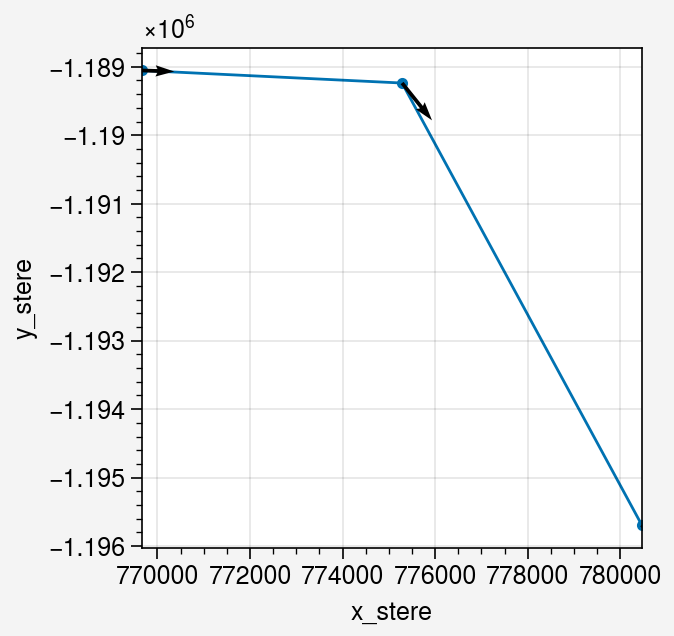

In [68]:
fig, ax = uplt.subplots()
time = pd.to_datetime('2019-06-13 12:00')
dt = pd.to_timedelta('36h')
# data = buoy_df_gridded.loc[slice(time - dt, time + dt), :]
# ax.plot(data.x_stere, data.y_stere, marker='.', zorder=0, lw=1)
# ax.quiver(data.x_stere, data.y_stere, data.u, data.v, scale=1)
# ax.format(yreverse=False, xreverse=False)


data_ift = ift_sel.loc[ift_sel.floe_id == '2019_04502']
data_ift = data_ift.set_index('datetime').loc[slice(time - dt, time + dt), :]
ax.plot(data_ift.x_stere, data_ift.y_stere, marker='.', zorder=0, lw=1)
ax.quiver(data_ift.x_stere, data_ift.y_stere, data_ift.u, data_ift.v, scale=1)
ax.format(yreverse=False, xreverse=False)


In [69]:
ift_sel.loc[ift_sel.dist < 25e3, ['u', 'iabp_u', 'v', 'iabp_v']]

,u,iabp_u,v,iabp_v
3589,0.059932,0.066472,-0.074656,-0.087435
3695,0.036365,0.066472,-0.074809,-0.087435
3833,NaN,0.066472,NaN,-0.087435
4119,0.059792,0.066472,-0.070934,-0.087435


In [636]:
for buoy in results:
    print(buoy, len(results[buoy]))

2005_800003 11
2008_900014 11
2013_900049 9
2015_137813 10
2015_300234060890090 1
2015_300234060894080 5
2016_300234062553800 33
2016_300234062784540 6
2019_300234066304040 42
2019_300234066341810 9
2020_300234066342810 6
2020_300234066342820 18
2020_300234066413390 1


In [73]:
ift_sel.datetime.min()

Timestamp('2019-04-01 12:00:00')

In [80]:
ift_sel[['datetime', 'u']].sort_values('datetime')

,datetime,u
0,2019-04-01 12:00:00,-0.000177
107,2019-04-01 12:00:00,0.035386
103,2019-04-01 12:00:00,0.032462
42,2019-04-01 12:00:00,-0.000088
31,2019-04-01 12:00:00,0.000000
...,...,...
4228,2019-07-04 12:00:00,NaN
4231,2019-07-19 12:00:00,-0.032779
4229,2019-07-19 12:00:00,0.092640
4230,2019-07-20 12:00:00,NaN


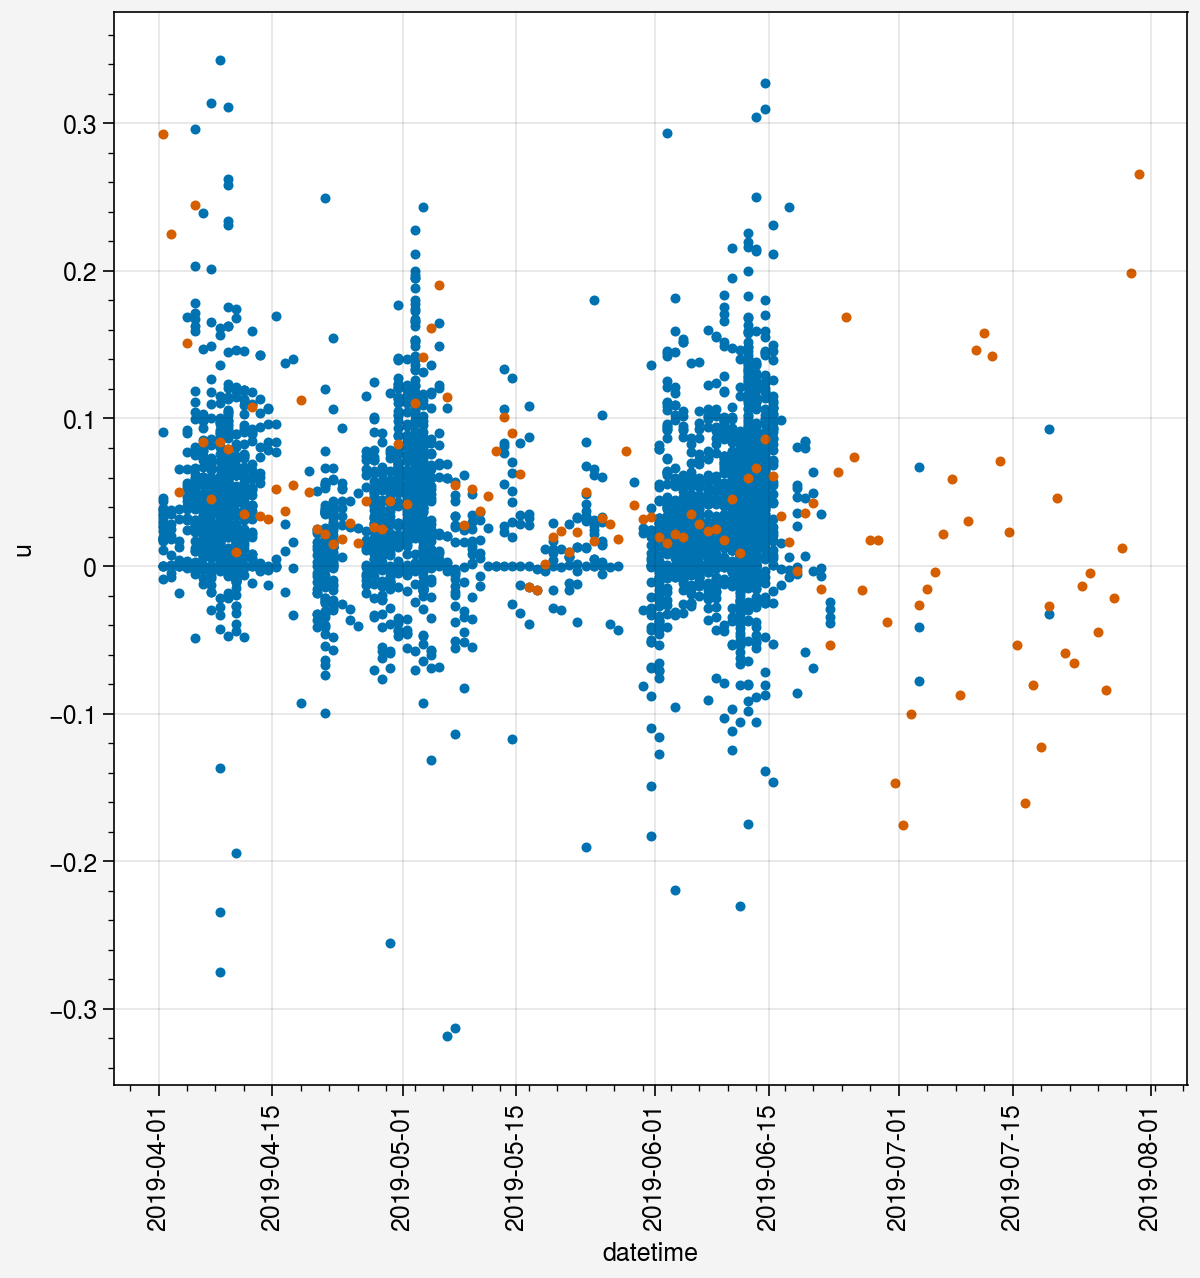

In [82]:
fig, ax = pplt.subplots(width=6)
ax.scatter(ift_sel.datetime, ift_sel.u, m='.', cmap='spectral')
ax.scatter(buoy_df_gridded.u, m='.')


KeyboardInterrupt: 

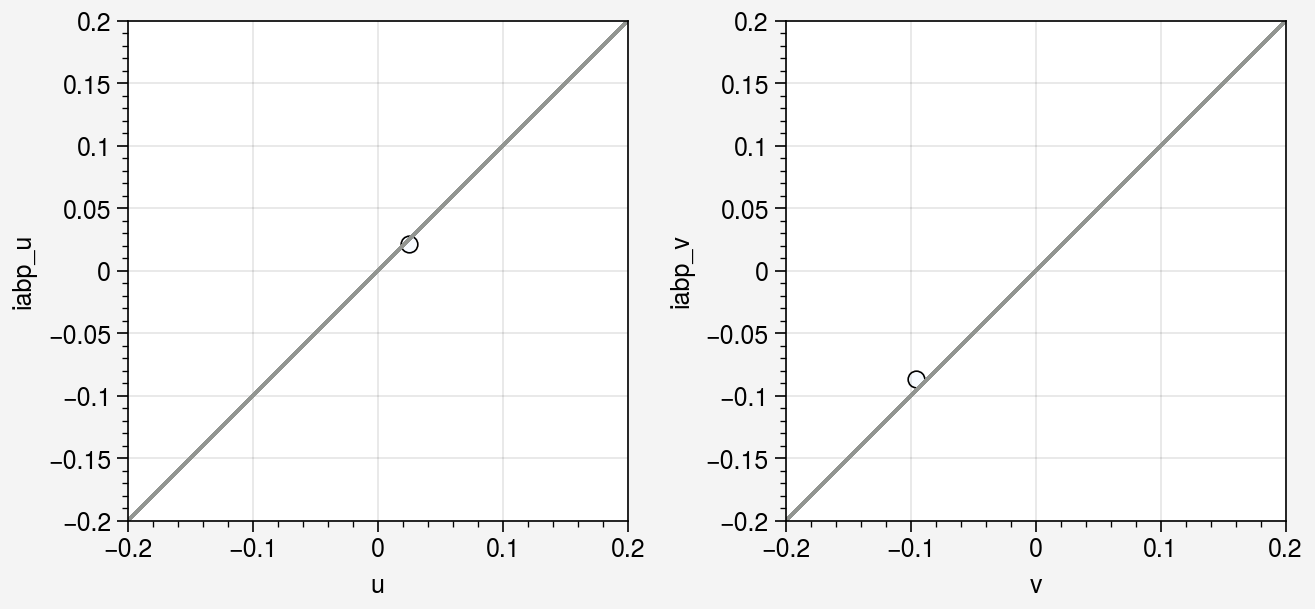

In [83]:
fig, ax = uplt.subplots(ncols=2, aspect=1, share=False)
for buoy in results:
    ift_sel = results[buoy]
    if len(ift_sel) > 0:
        idx = ift_sel.distance < 10e3
        ax[0].scatter(ift_sel.loc[idx, 'u'], ift_sel.loc[idx, 'iabp_u'], c=ift_sel.loc[idx, 'distance'], m='o', cmap='blues', edgecolor='k')
        ax[1].scatter(ift_sel.loc[idx, 'v'], ift_sel.loc[idx, 'iabp_v'], c=ift_sel.loc[idx, 'distance'], m='o', cmap='blues', edgecolor='k')
    ax.format(ylim=(-0.2, 0.2), xlim=(-0.2, 0.2))
    ax.plot([-0.2, 0.2], [-0.2, 0.2], lw=1, color='gray')

In [629]:
pd.concat(results)[['u', 'v', 'iabp_u', 'iabp_v']].corr()

,u,v,iabp_u,iabp_v
u,1.000000,0.357345,0.213652,0.45421
v,0.357345,1.000000,0.119910,0.67246
iabp_u,0.213652,0.119910,1.000000,0.08033
iabp_v,0.454210,0.672460,0.080330,1.00000
